In [1]:
import fastai
import pandas as pd

In [2]:
fastai.__version__

'1.0.60'

In [3]:
import wget
import time
import os
import copy

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [5]:
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [6]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [9]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))

In [8]:
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [12]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_224by224',suffix='.png')

In [13]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_224by224',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [84]:
# Let's inspect the object
# src.__dir__()

In [14]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: /home/ubuntu/datasets/human-protein-atlas>

In [15]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
0;21,1,25,4;0,0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [16]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [17]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

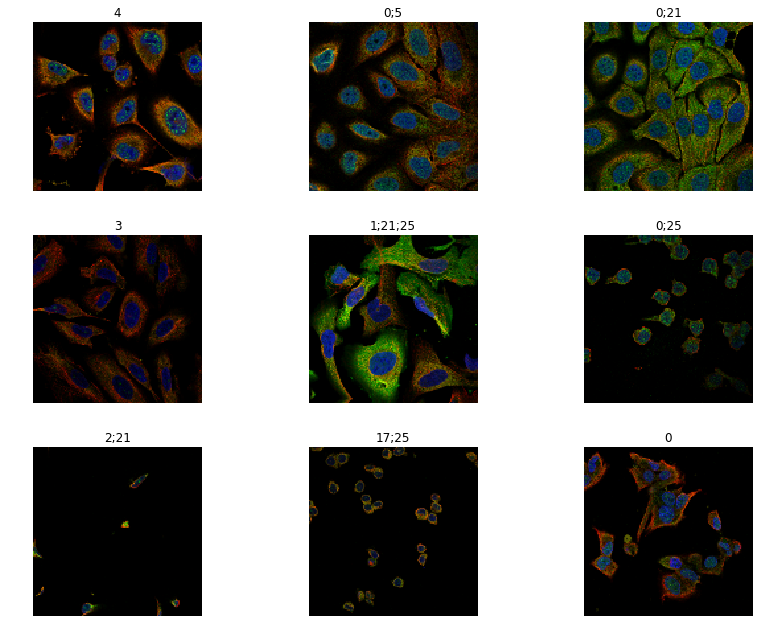

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
arch = models.resnet152
acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
f1_score = partial(fbeta, thresh=0.2, beta=1)
# f1_callback = F1_callback()

In [20]:
setattr(src, 'device', 'cuda') 

In [21]:
learn = cnn_learner(data, arch, metrics=[acc_02, f1_score])

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


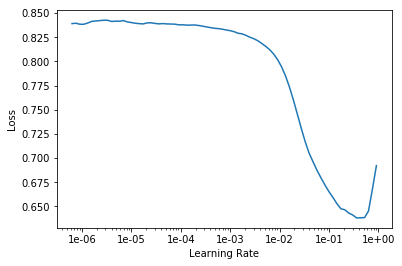

In [23]:
learn.recorder.plot()

In [24]:
lr = 0.01

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.164170,0.155359,0.928842,0.389434,01:27
1,0.149948,0.147403,0.934457,0.431466,01:29
2,0.145339,0.140879,0.939475,0.460657,01:28
3,0.138942,0.135809,0.937503,0.477891,01:29
4,0.135912,0.134616,0.938330,0.485880,01:29


In [22]:
# for size 62
# learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.172146,0.164291,0.924623,0.352332,00:36
1,0.159438,0.158683,0.932273,0.367234,00:37
2,0.155335,0.153910,0.931985,0.384507,00:37
3,0.152571,0.151191,0.934313,0.400776,00:37
4,0.151080,0.149926,0.933940,0.410561,00:38


In [30]:
learn.save('stage-1-rn152')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


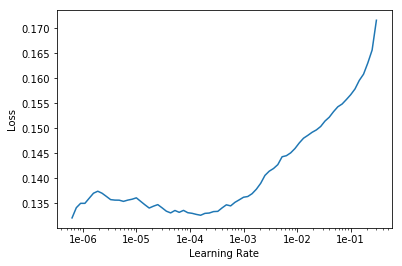

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137983,0.138483,0.936710,0.475345,01:58
1,0.136610,0.135829,0.937078,0.477074,02:00
2,0.131540,0.129021,0.940325,0.515624,02:03
3,0.123066,0.124870,0.941509,0.534970,02:01
4,0.118847,0.123328,0.941567,0.538634,02:00


In [34]:
learn.save('stage-2-rn152')

### Testing the data

In [25]:
learn.load('stage-2-rn152')

Learner(data=ImageDataBunch;

Train: LabelList (24858 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: /home/ubuntu/datasets/human-protein-atlas;

Valid: LabelList (6214 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
0;21,1,25,4;0,0
Path: /home/ubuntu/datasets/human-protein-atlas;

Test: LabelList (11702 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, 

In [37]:
learn.data.batch_size

64

__Making the predictions__

In [31]:
preds, _ = learn.get_preds(DatasetType.Test)

In [32]:
type(preds), preds.shape

(torch.Tensor, torch.Size([11702, 28]))

In [33]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [34]:
labelled_preds[:5]

['2 3', '', '0 25', '0 25', '0 21 25']

In [35]:
len(labelled_preds)

11702

In [38]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_224by224/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_224by224/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

In [44]:
fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
fnames[0]

'00008af0-bad0-11e8-b2b8-ac1f6b6435d0'

In [45]:
len(fnames),len(labelled_preds)

(11702, 11702)

In [48]:
df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])

In [49]:
df.head(20)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2 3
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 21 25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0 4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 25 7
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 25


In [50]:
df.to_csv('protein_classification.csv', header=True, index=False)

In [51]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Baseline Model"

100%|█████████████████████████████████████████| 482k/482k [00:00<00:00, 726kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [52]:
# View results
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt

In [53]:
!cat results.txt

fileName                    date                 description     status    publicScore  privateScore  
--------------------------  -------------------  --------------  --------  -----------  ------------  
protein_classification.csv  2020-02-06 19:22:45  Baseline Model  complete  0.20878      0.19654       


In [55]:
sample_submission = pd.read_csv(data_root+'sample_submission.csv')
sample_submission.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [62]:
df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
df2.shape

(11702, 2)

In [63]:
df2.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2 3
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 21 25


In [64]:
df2.to_csv('protein_classification.csv', header=True, index=False)

In [65]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Baseline Model v2"

100%|█████████████████████████████████████████| 482k/482k [00:00<00:00, 718kB/s]
Successfully submitted to Human Protein Atlas Image Classification

Let's try playing around with the threshold

In [66]:
thresh = 0.25
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
df.to_csv('protein_classification.csv', header=True, index=False)

In [67]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Baseline Model v3 with thrsd 0.25"

100%|█████████████████████████████████████████| 473k/473k [00:00<00:00, 757kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [69]:
thresh = 0.17
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
df.to_csv('protein_classification.csv', header=True, index=False)
#df.head(5)

In [70]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Baseline Model v4 with threshold 0.17"

100%|█████████████████████████████████████████| 489k/489k [00:00<00:00, 747kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [71]:
thresh = 0.15
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_224by224/','')
df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
df.to_csv('protein_classification.csv', header=True, index=False)
#df.head(5)

In [72]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Baseline Model v4 with threshold 0.15"

100%|█████████████████████████████████████████| 495k/495k [00:00<00:00, 727kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [73]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!cat results.txt

fileName                    date                 description                            status    publicScore  privateScore  
--------------------------  -------------------  -------------------------------------  --------  -----------  ------------  
protein_classification.csv  2020-02-06 19:51:34  Baseline Model v4 with threshold 0.17  complete  0.22196      0.20771       
protein_classification.csv  2020-02-06 19:50:34  Baseline Model v4 with threshold 0.17  complete  0.21858      0.20388       
protein_classification.csv  2020-02-06 19:48:26  Baseline Model v3 with thrsd 0.25      complete  0.19699      0.18535       
protein_classification.csv  2020-02-06 19:42:10  Baseline Model v2 with threshold 0.2   complete  0.20878      0.19654       
protein_classification.csv  2020-02-06 19:22:45  Baseline Model                         complete  0.20878      0.19654       
